In [2]:
from scipy.io import loadmat
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.linear_model import Lasso
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from matplotlib import pyplot as plt

## Data Preprocessing

In [3]:
data = loadmat("adjdata.mat")
adj_mat = data['adj_aveROI']
adj_mat = adj_mat.flatten()

In [46]:
# create a dataframe that is 1540 * 49 the combination of every two ROIs
def data_cleaning(X):
#     ''''
#     This funciton flattens each participant adj matrix into a column vector,
#     and concatenate together. 
#     Rows with no observed entries were removed.
#     ''''
    
    rows = X[0].shape[0]
    cols = X[0].shape[1]
    sub_num = X.shape[0]
    df_col = int(rows * cols / 2 - rows / 2)
    df = np.empty([0,df_col])
    col_name = []

    for subject in range(sub_num):
        sub_vec = []
        for i in range(rows):
            for j in range(cols):
                if i > j:
                    sub_vec.append(X[subject][i][j])
                    #col_name.append(str(i)+ "&" + str(j))
        sub_vec = np.array(sub_vec)
        df = (np.vstack((df,sub_vec)))
    for i in range(rows):
        for j in range(cols):
            if i > j:    
                col_name.append(str(i)+ "&" + str(j))
    
    empty_col = [col_name[i] for i in range(df_col) if np.isnan(df[:,i]).all() == True]
    empty_col_idx = [i for i in range(df_col) if np.isnan(df[:,i]).all() == True]
    for name in empty_col:
        col_name.remove(name)
    
    df_cleaned = np.delete(df, empty_col_idx, 1)
    df_cleaned = np.transpose(df_cleaned)
    missing_rate = np.sum(np.isnan(df_cleaned) == True) / (df_cleaned.shape[0] * df_cleaned.shape[1])

    print(f"Data dimension:{df_cleaned.shape}, missing rate:{missing_rate}")
    return df_cleaned, col_name

In [48]:
X, col_name = data_cleaning(adj_mat)

Data dimension:(1540, 49), missing rate:0.7344420885237212


### Observed entries for specific ROI

In [95]:
sub_num = adj_mat.shape[0]
ROI_num = adj_mat[0].shape[0]

#for sub in range(sub_num):

58

### The overview of missing data locations

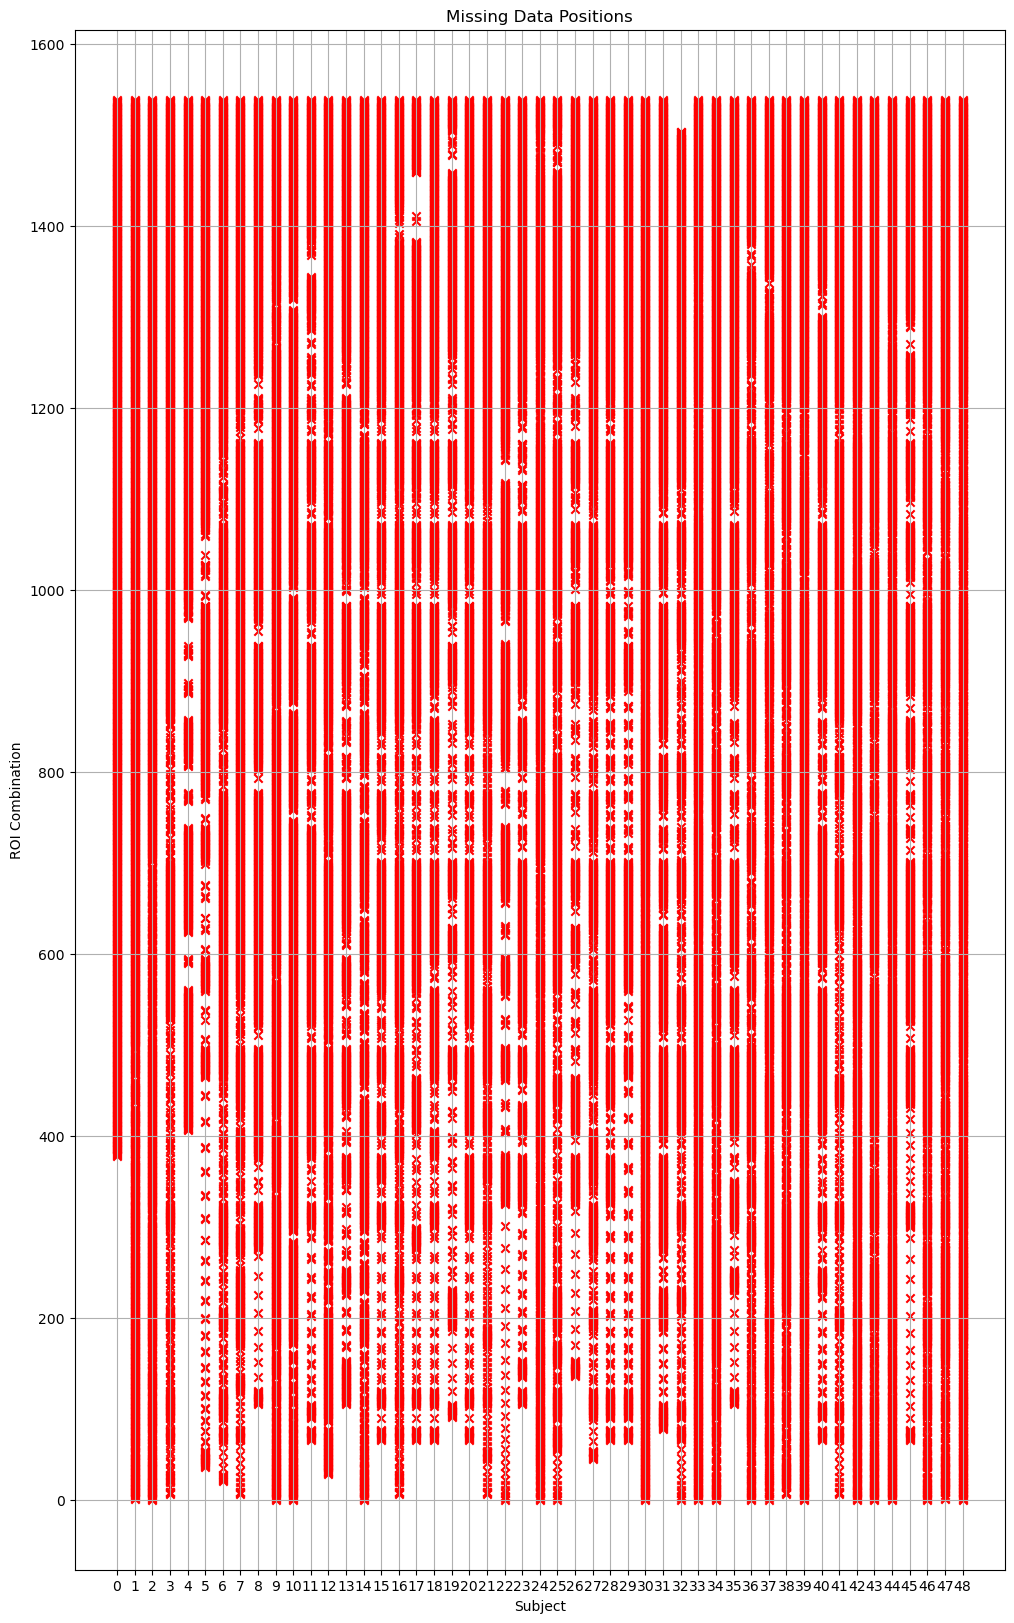

In [67]:
missing_mask = np.isnan(X)
x_coords, y_coords = np.where(missing_mask)
plt.figure(figsize=(12, 20))
plt.scatter(y_coords, x_coords, marker='x', color='red')
plt.xlabel('Subject')
plt.ylabel('ROI Combination')
plt.title('Missing Data Positions')
plt.xticks(np.arange(0,49))
plt.grid(True)
plt.show()

### Every 100 ROI combinations missing data pattern

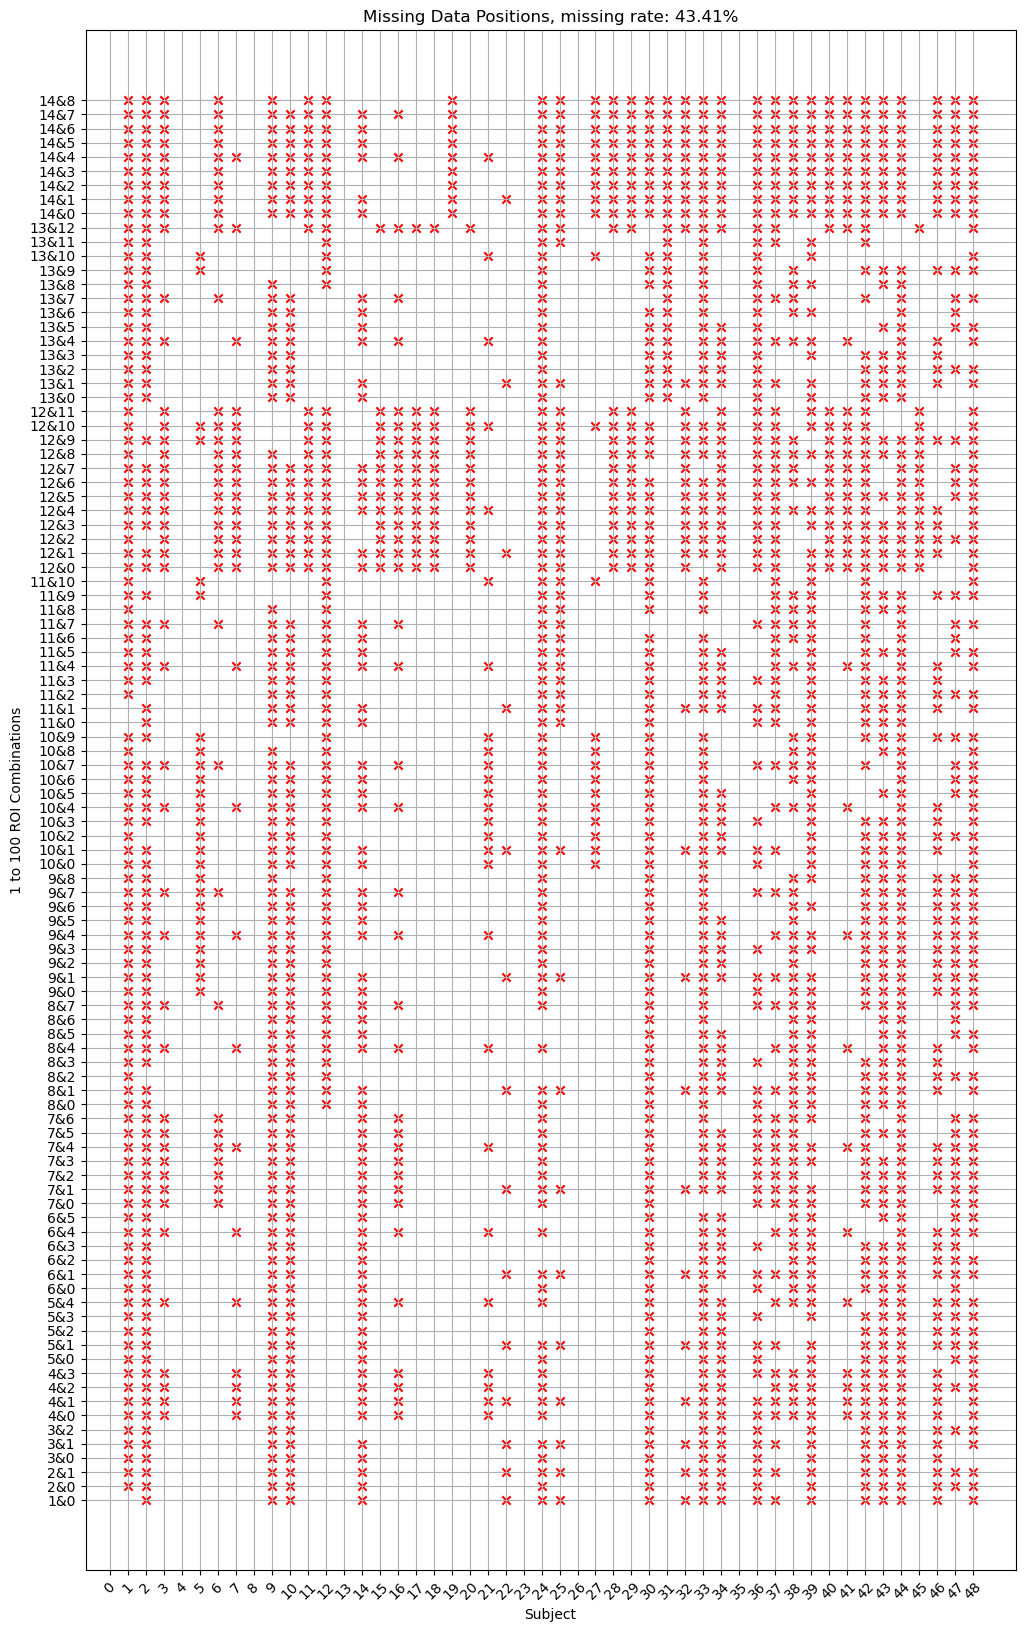

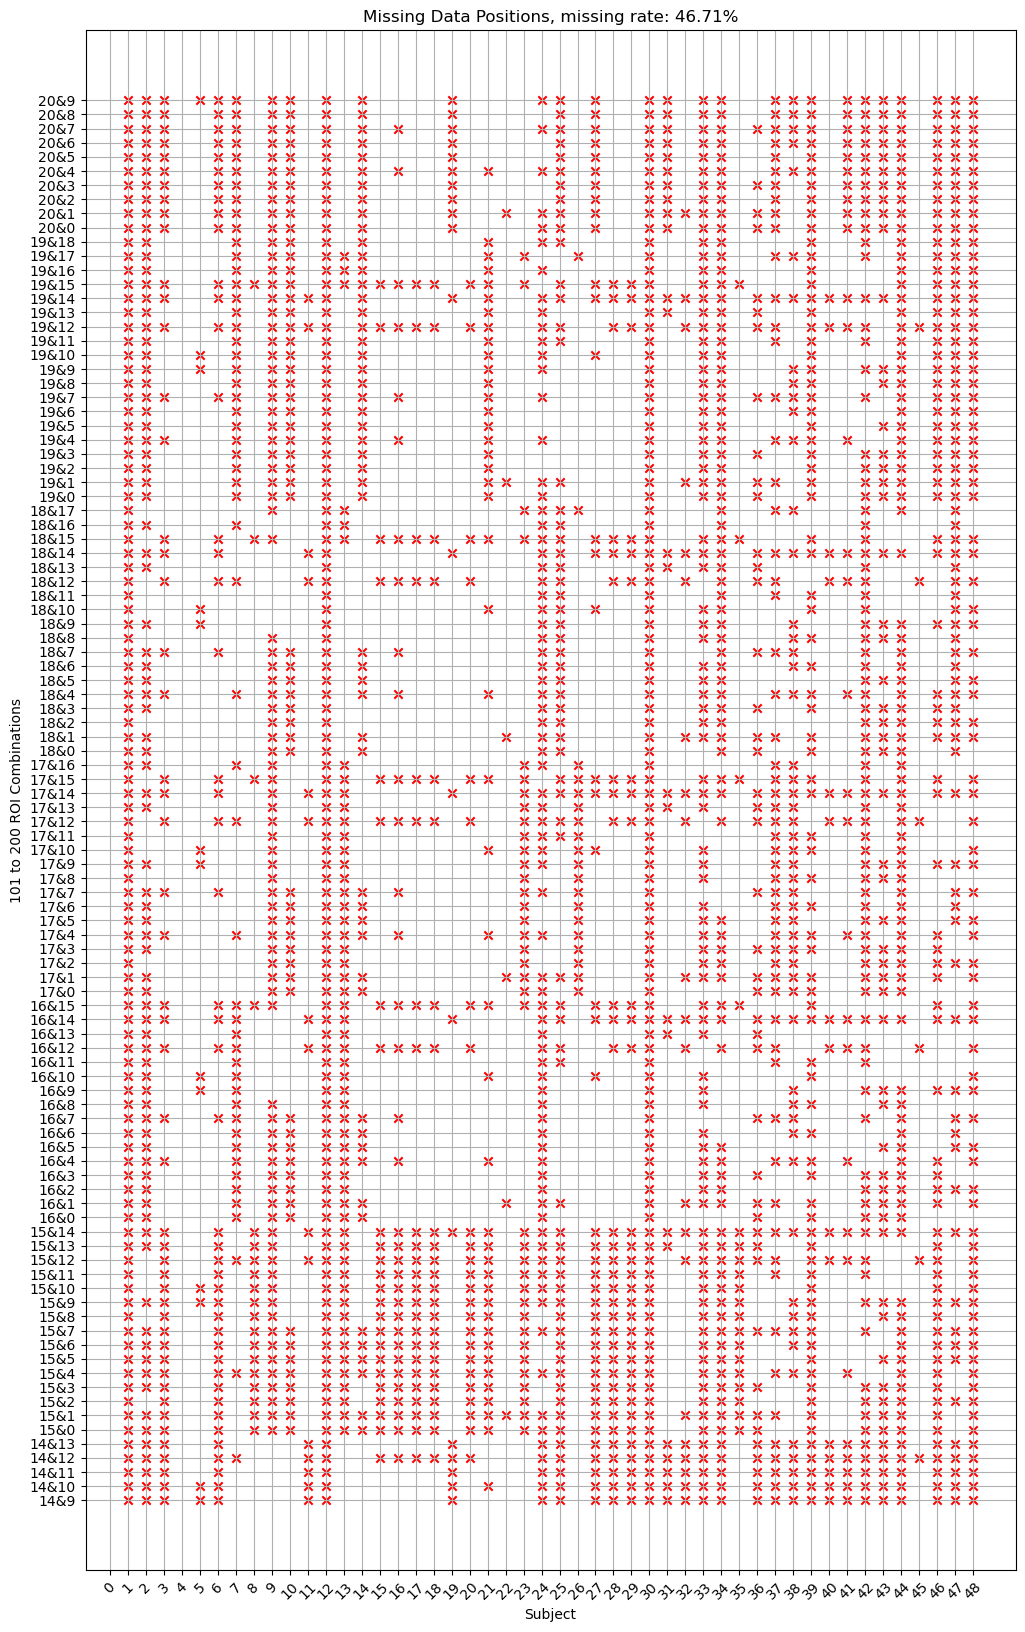

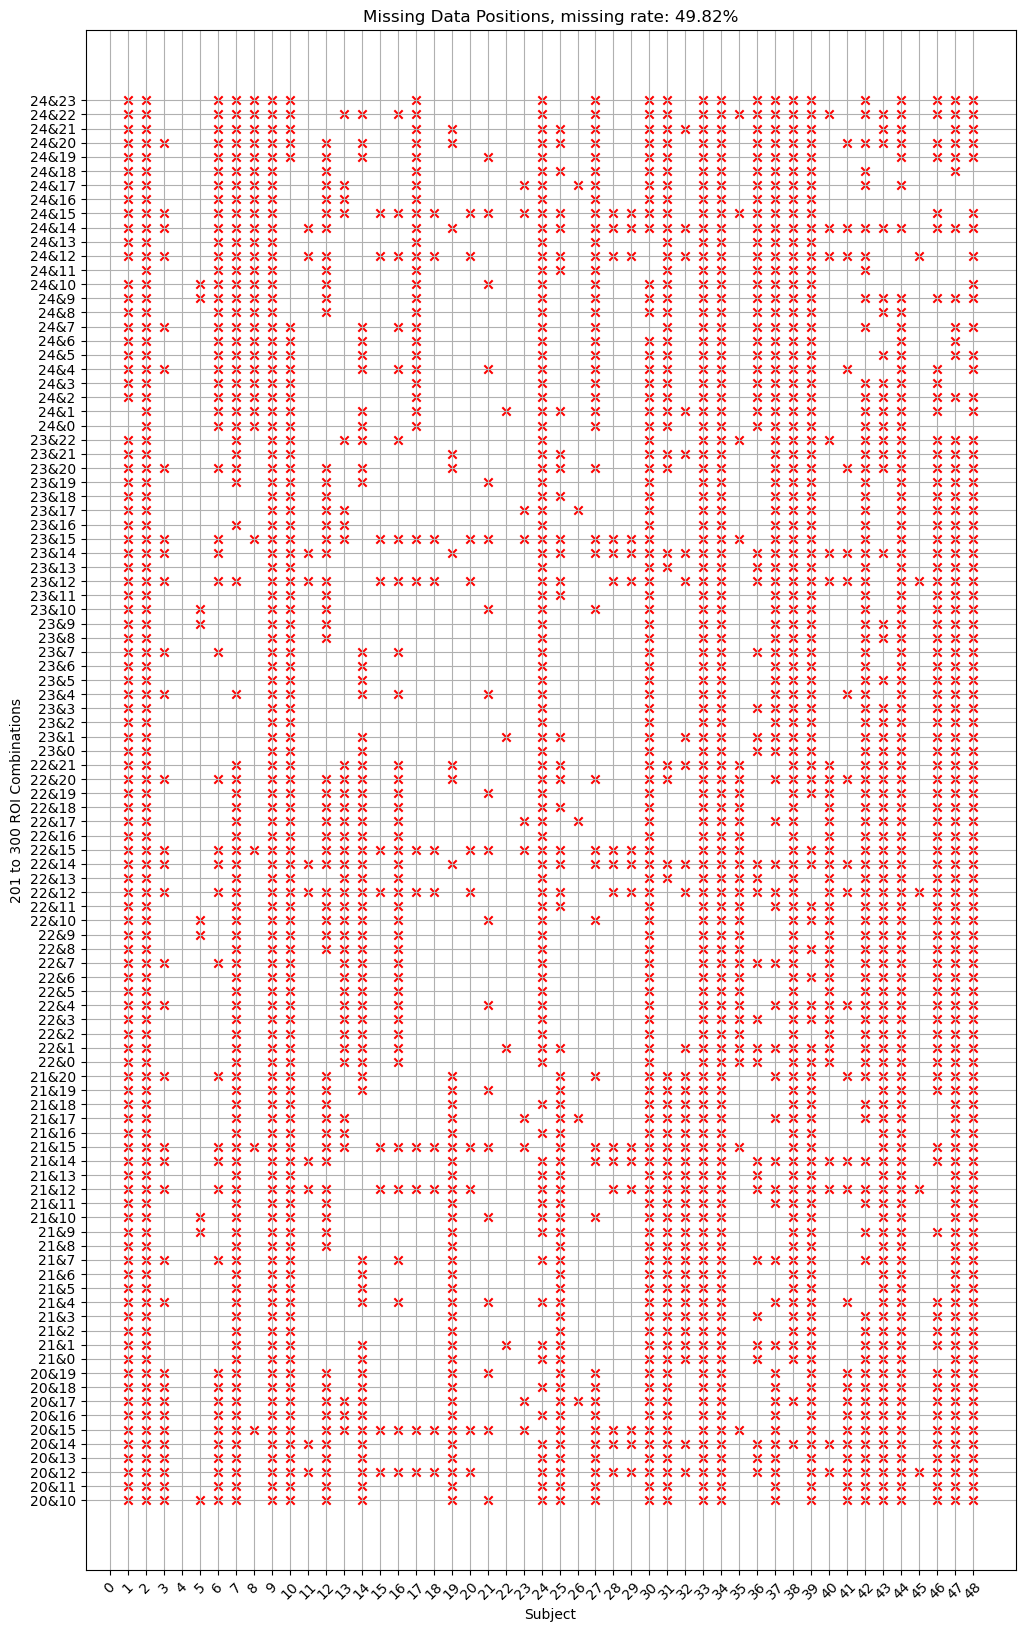

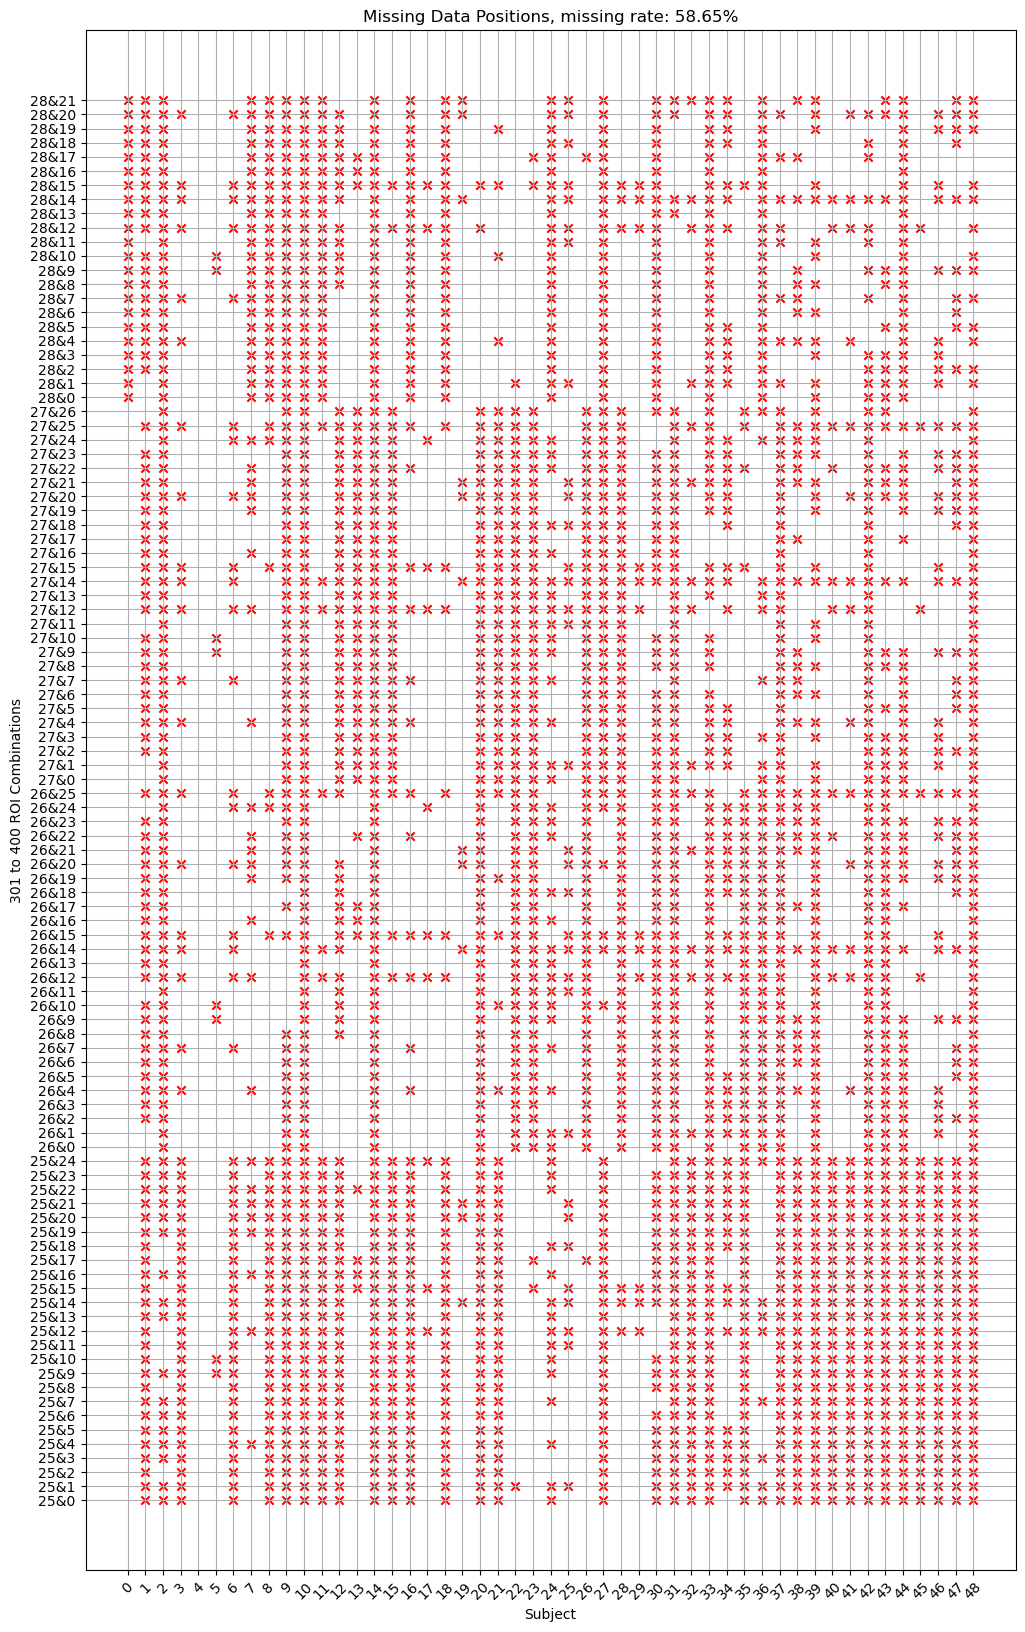

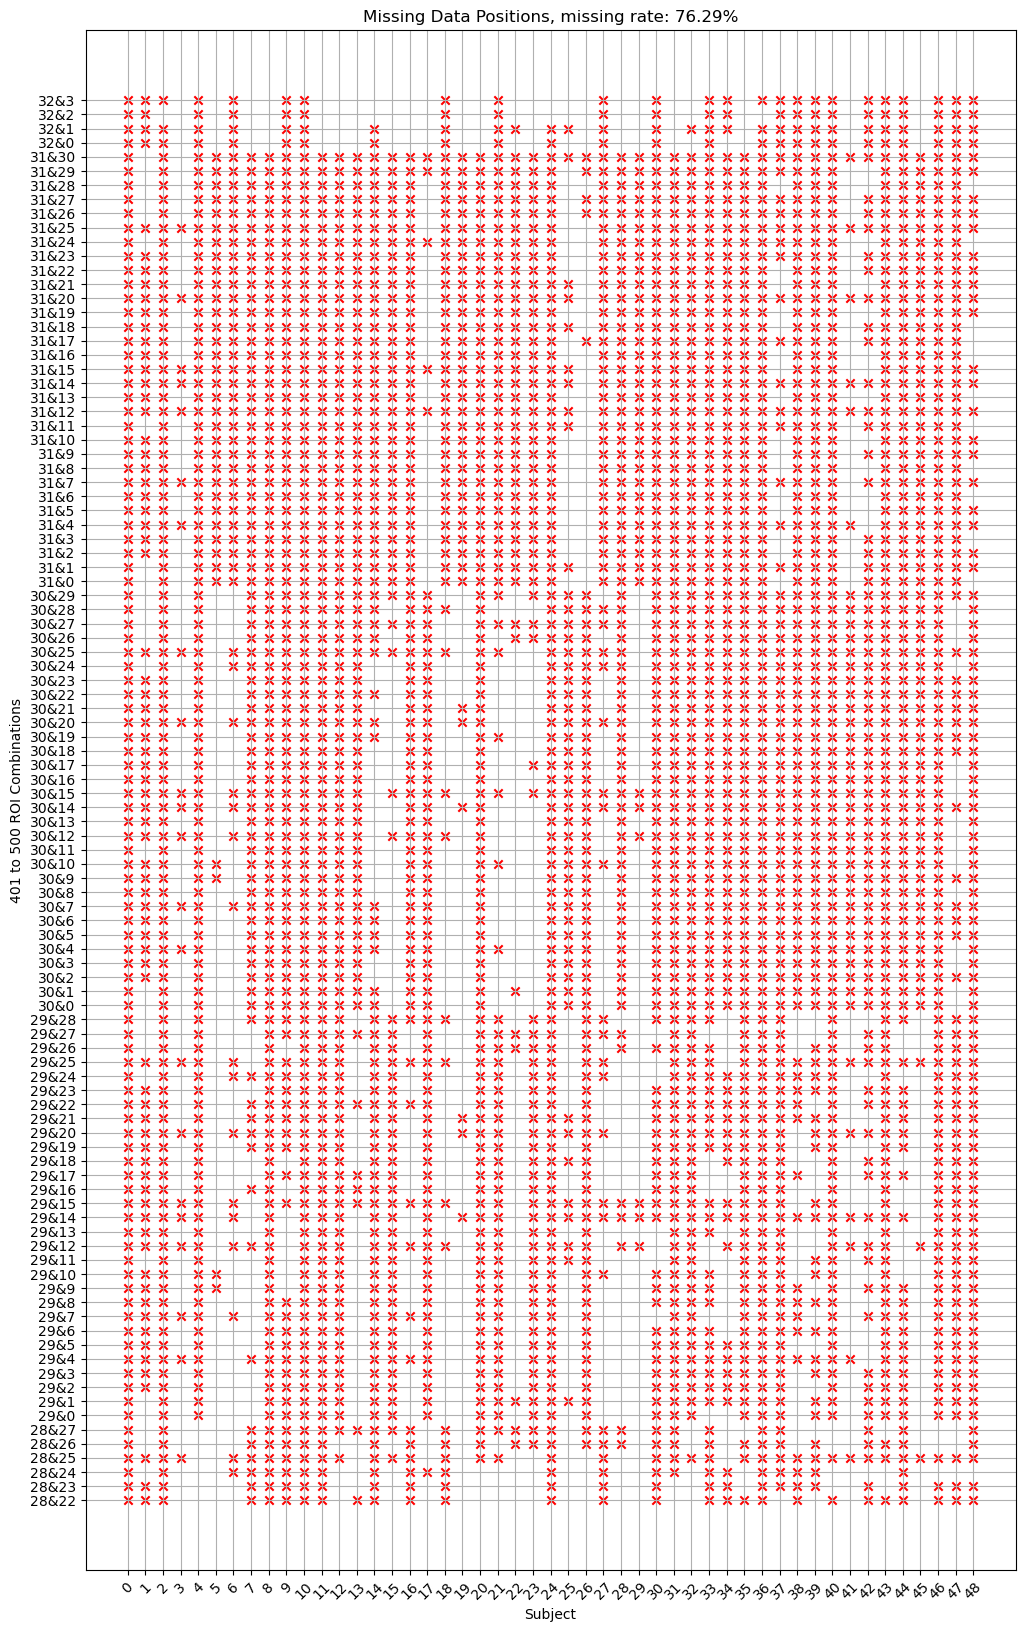

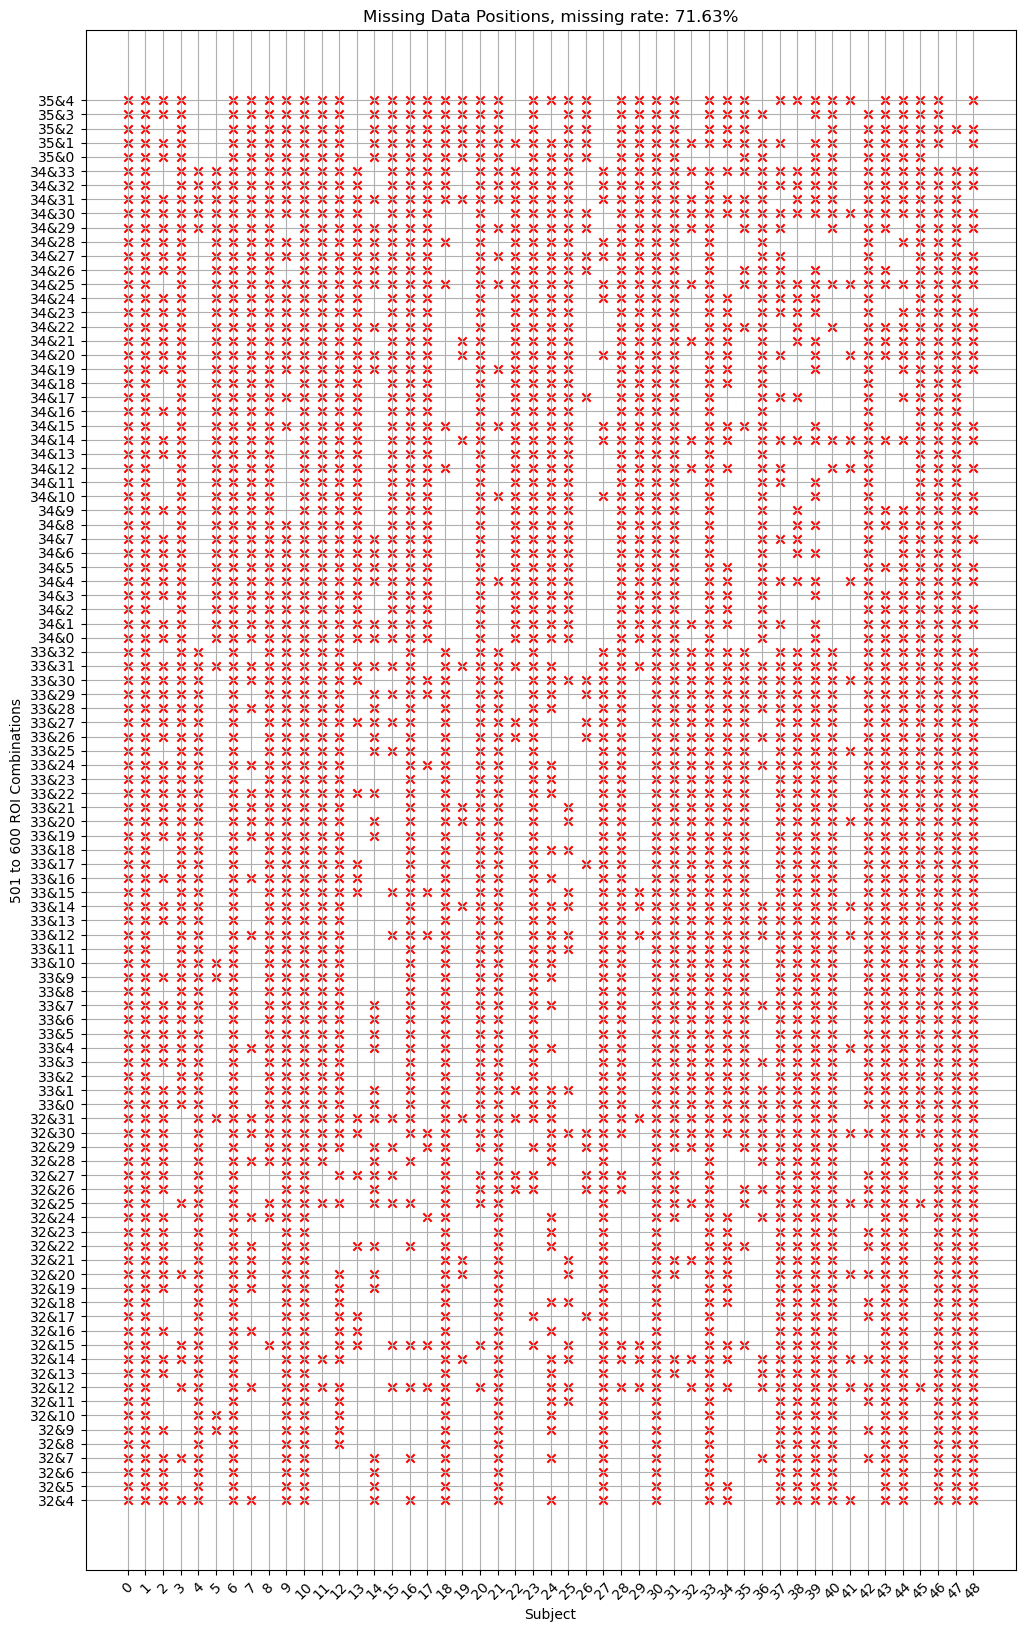

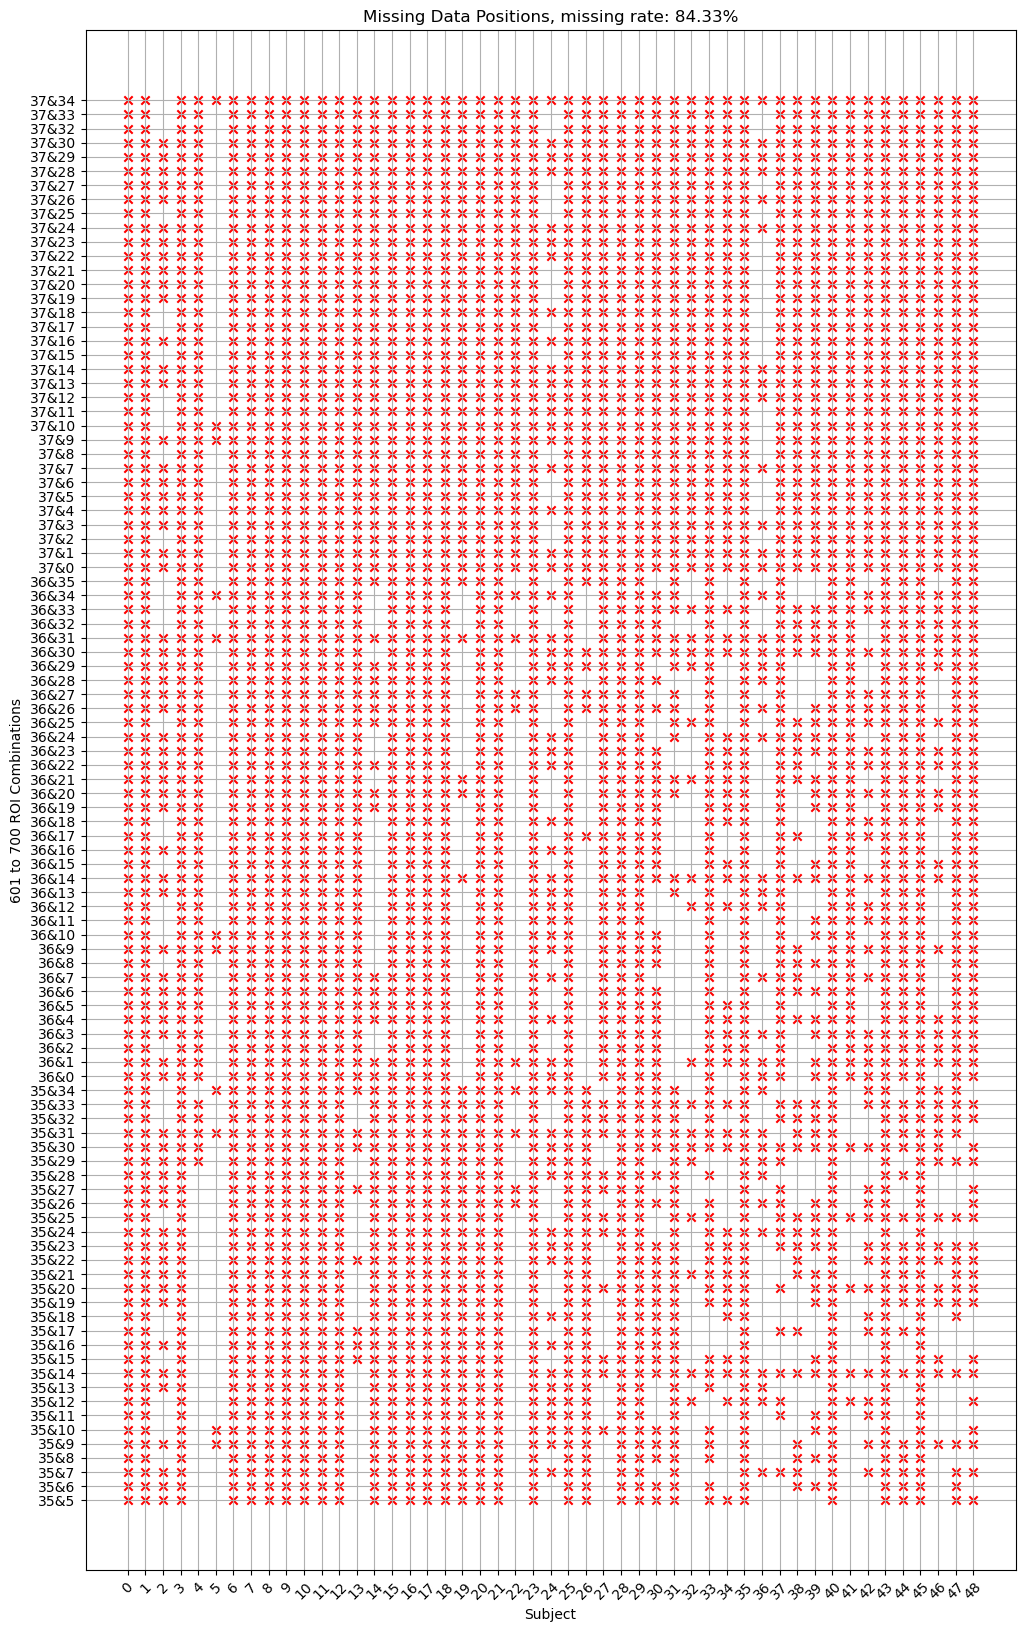

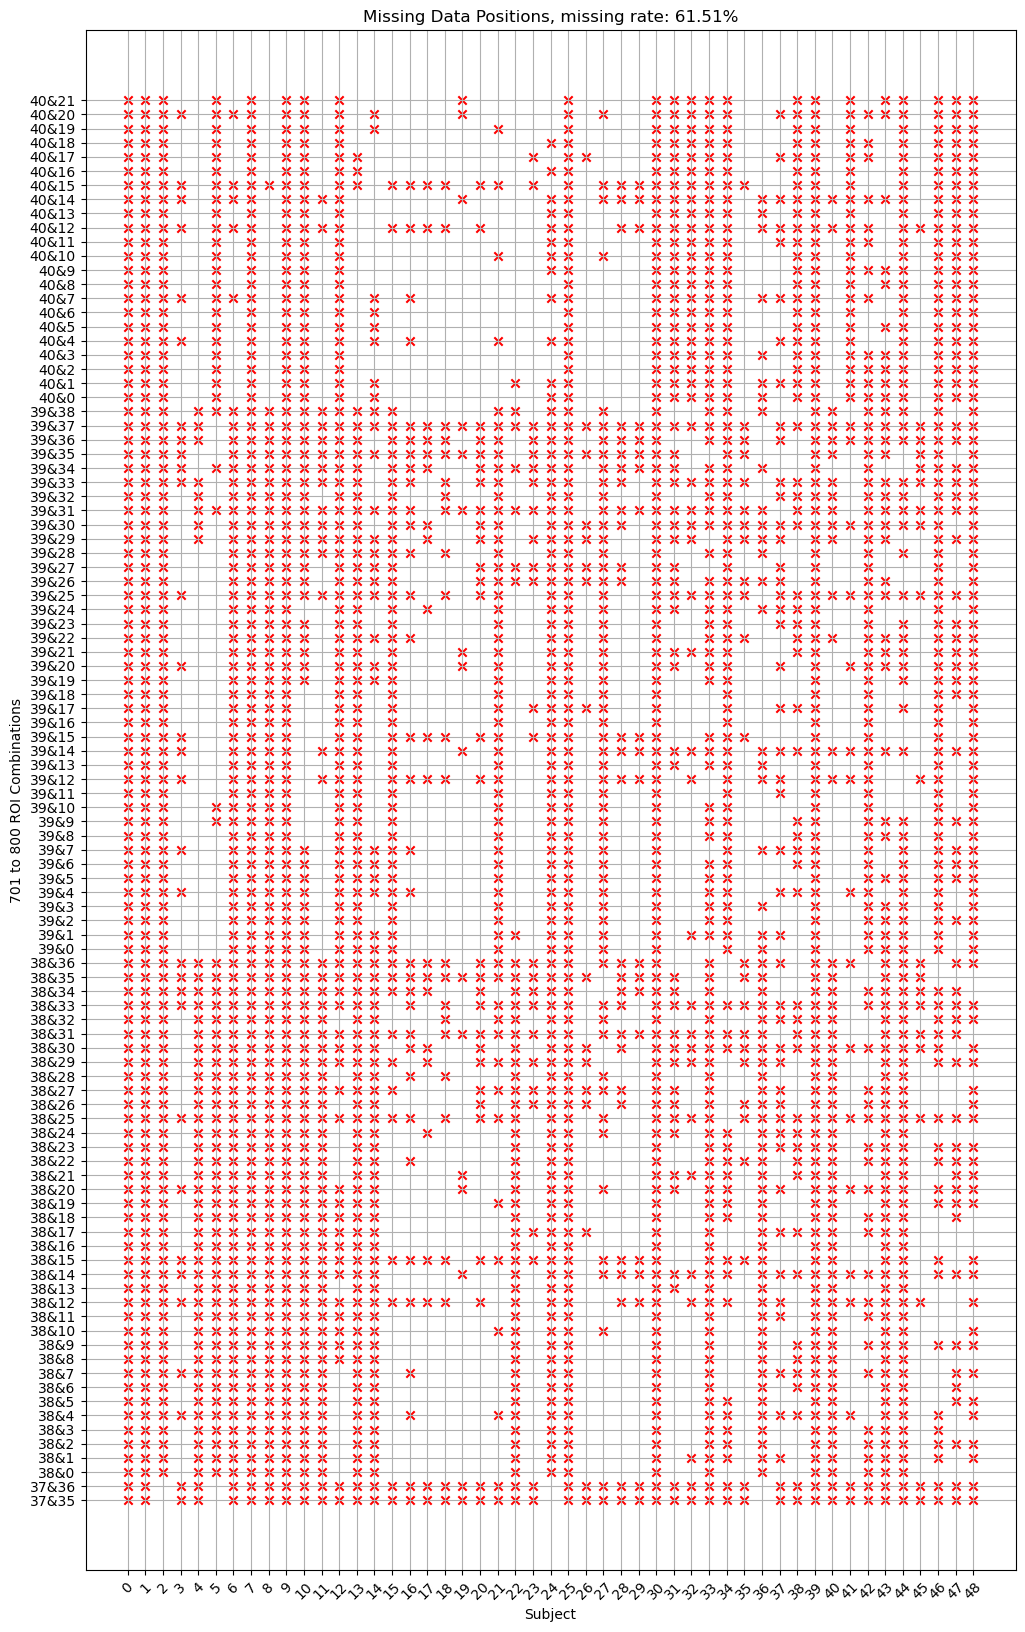

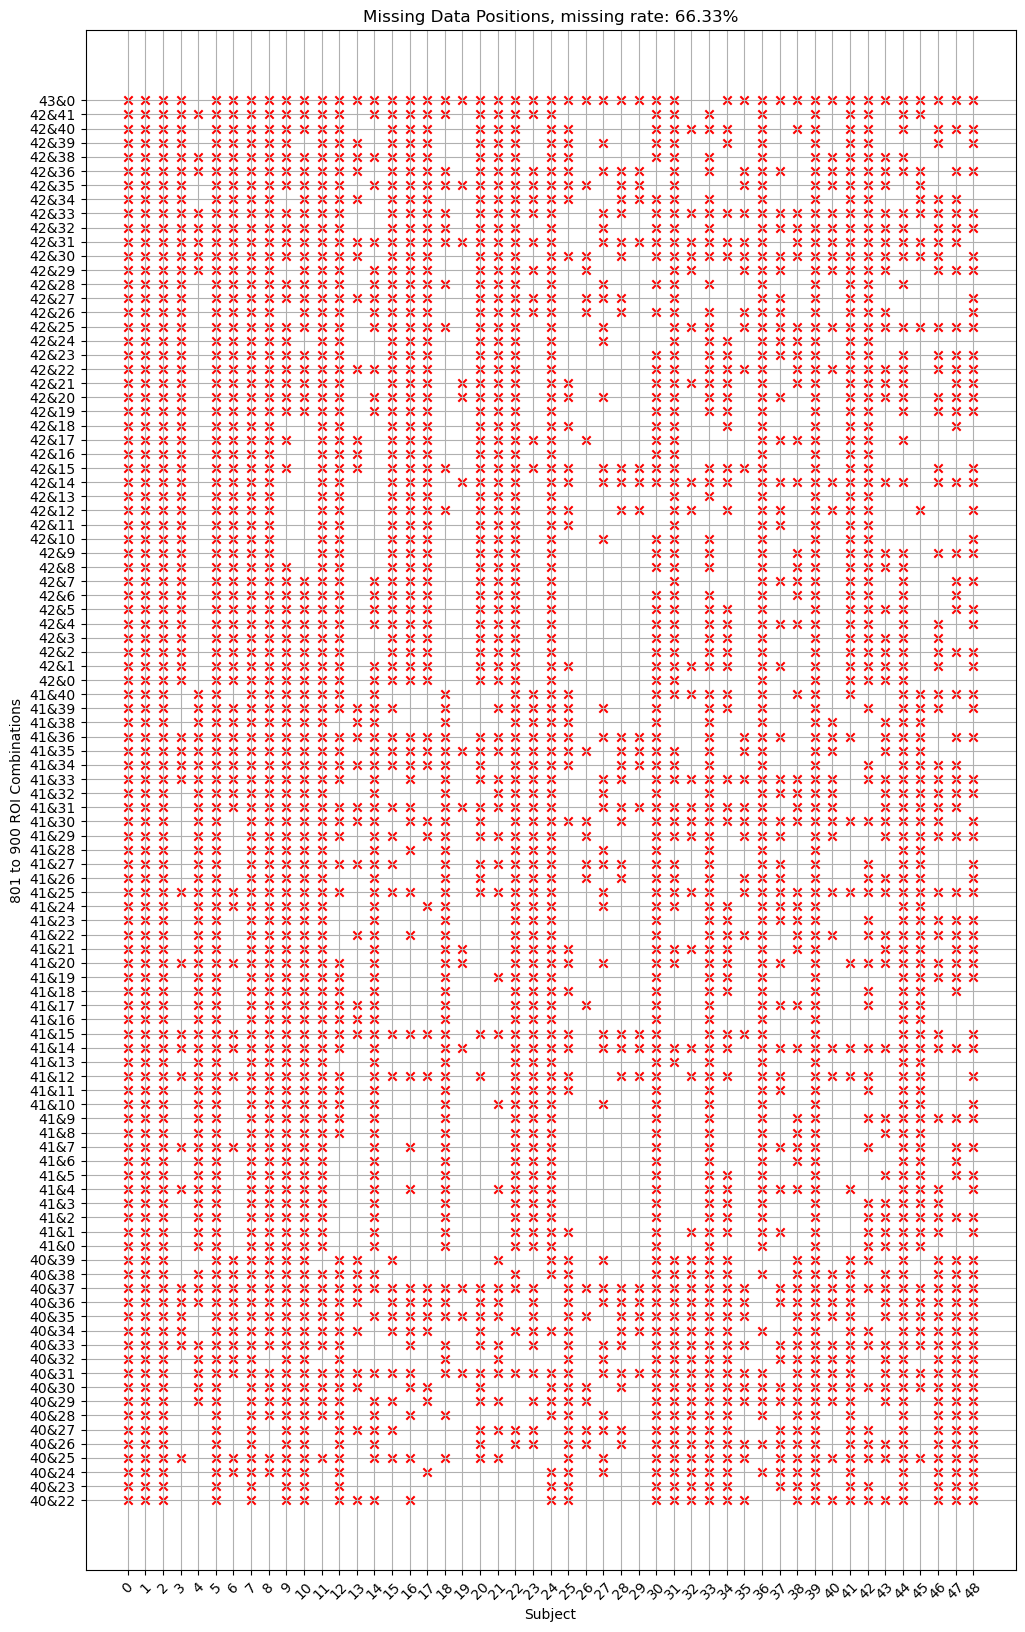

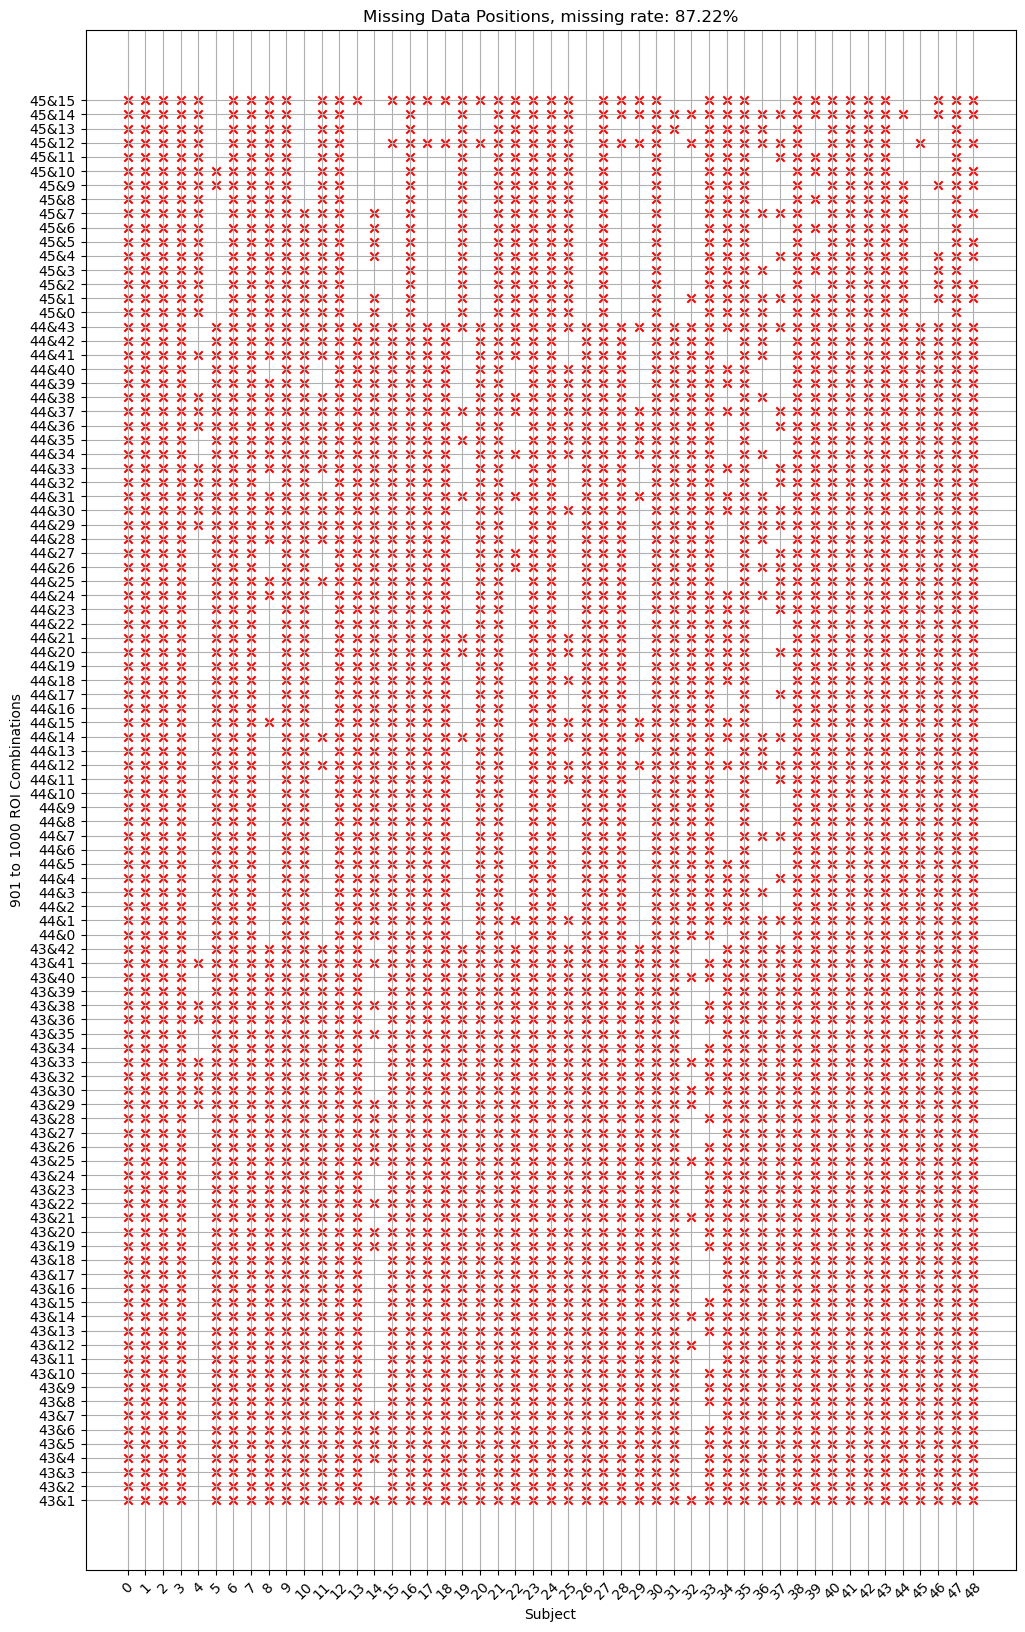

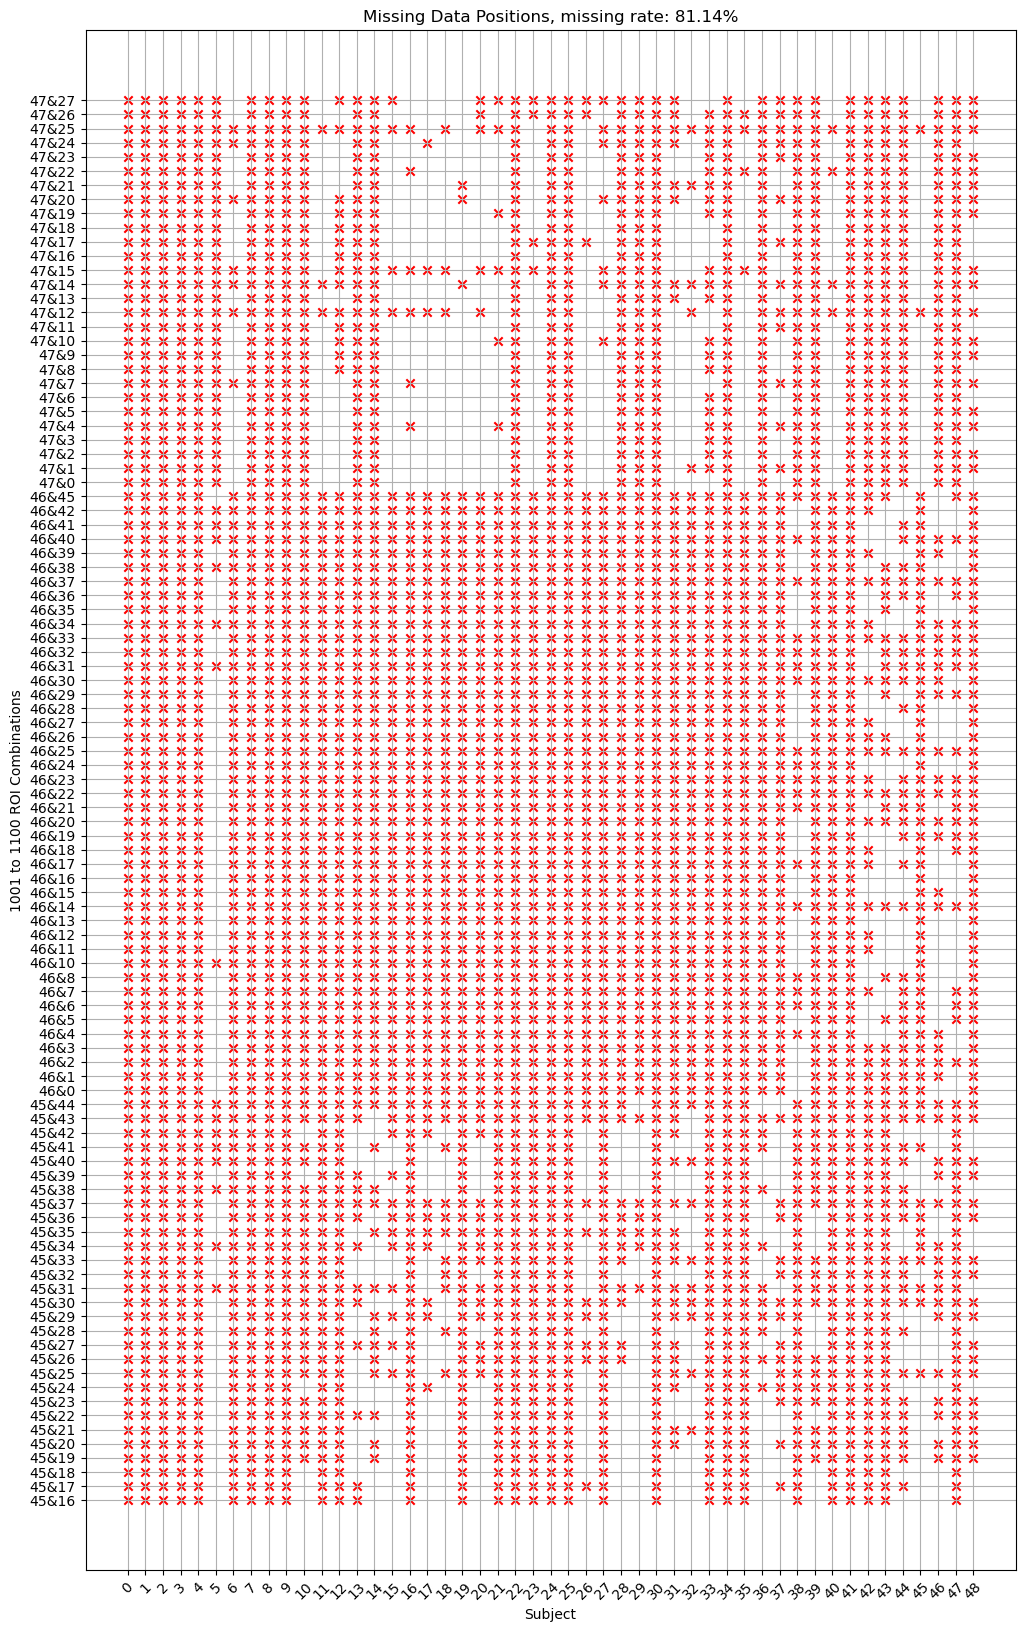

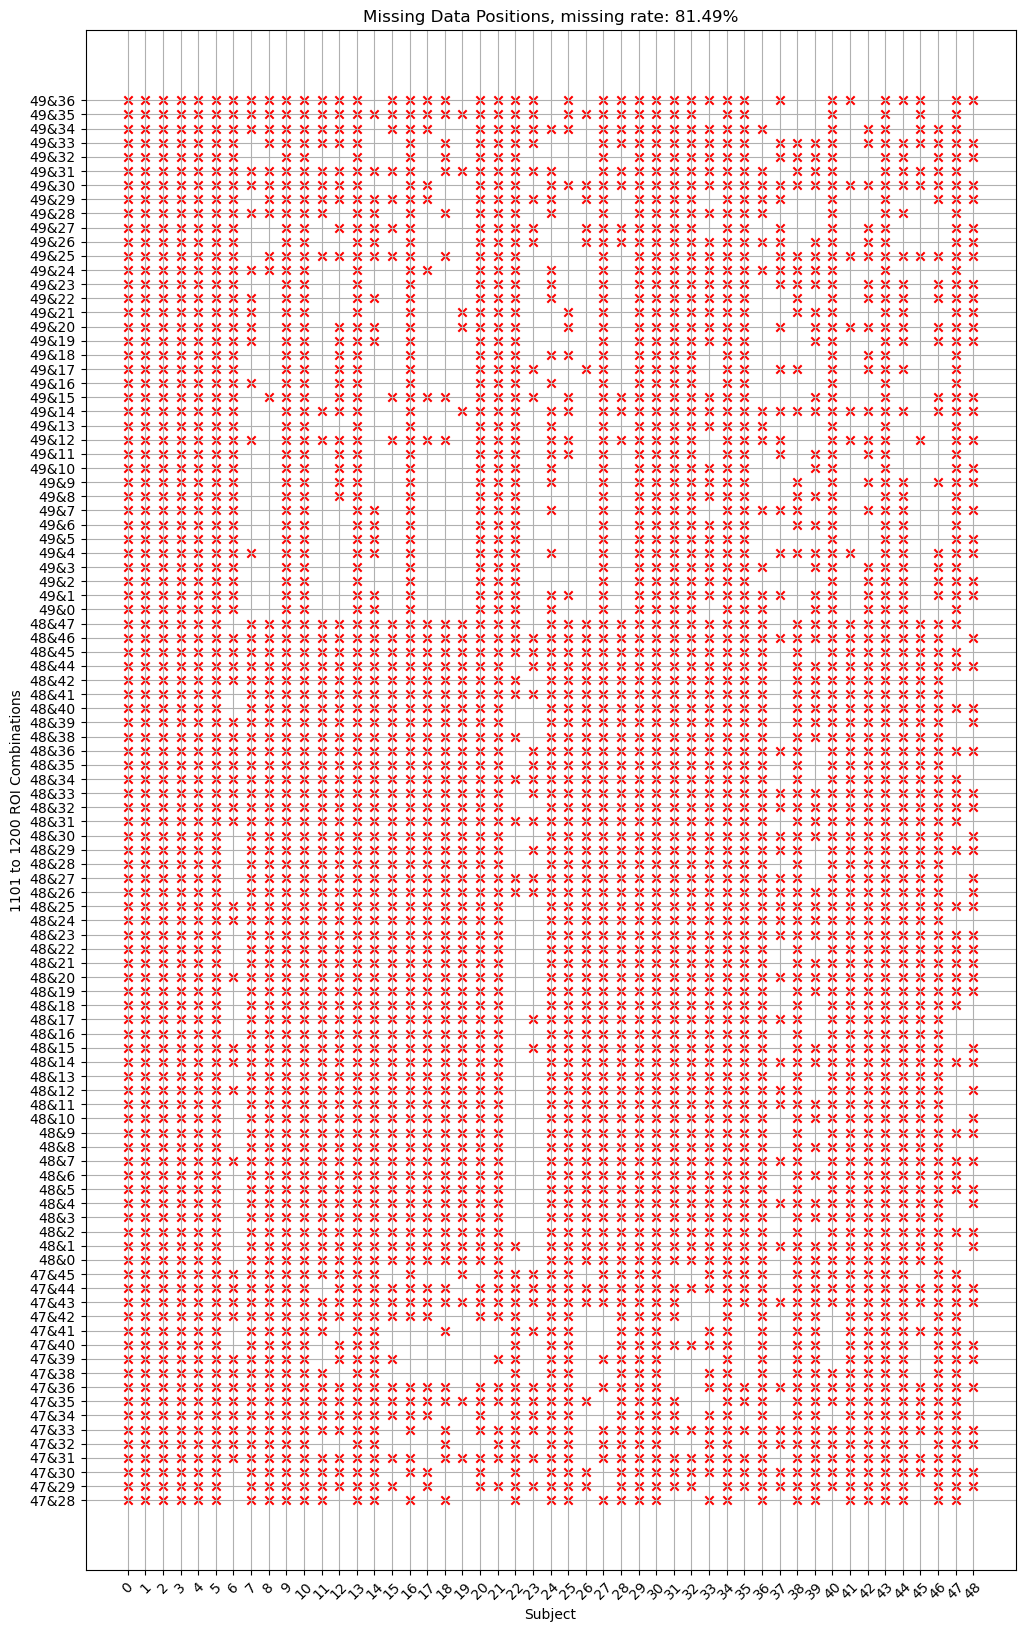

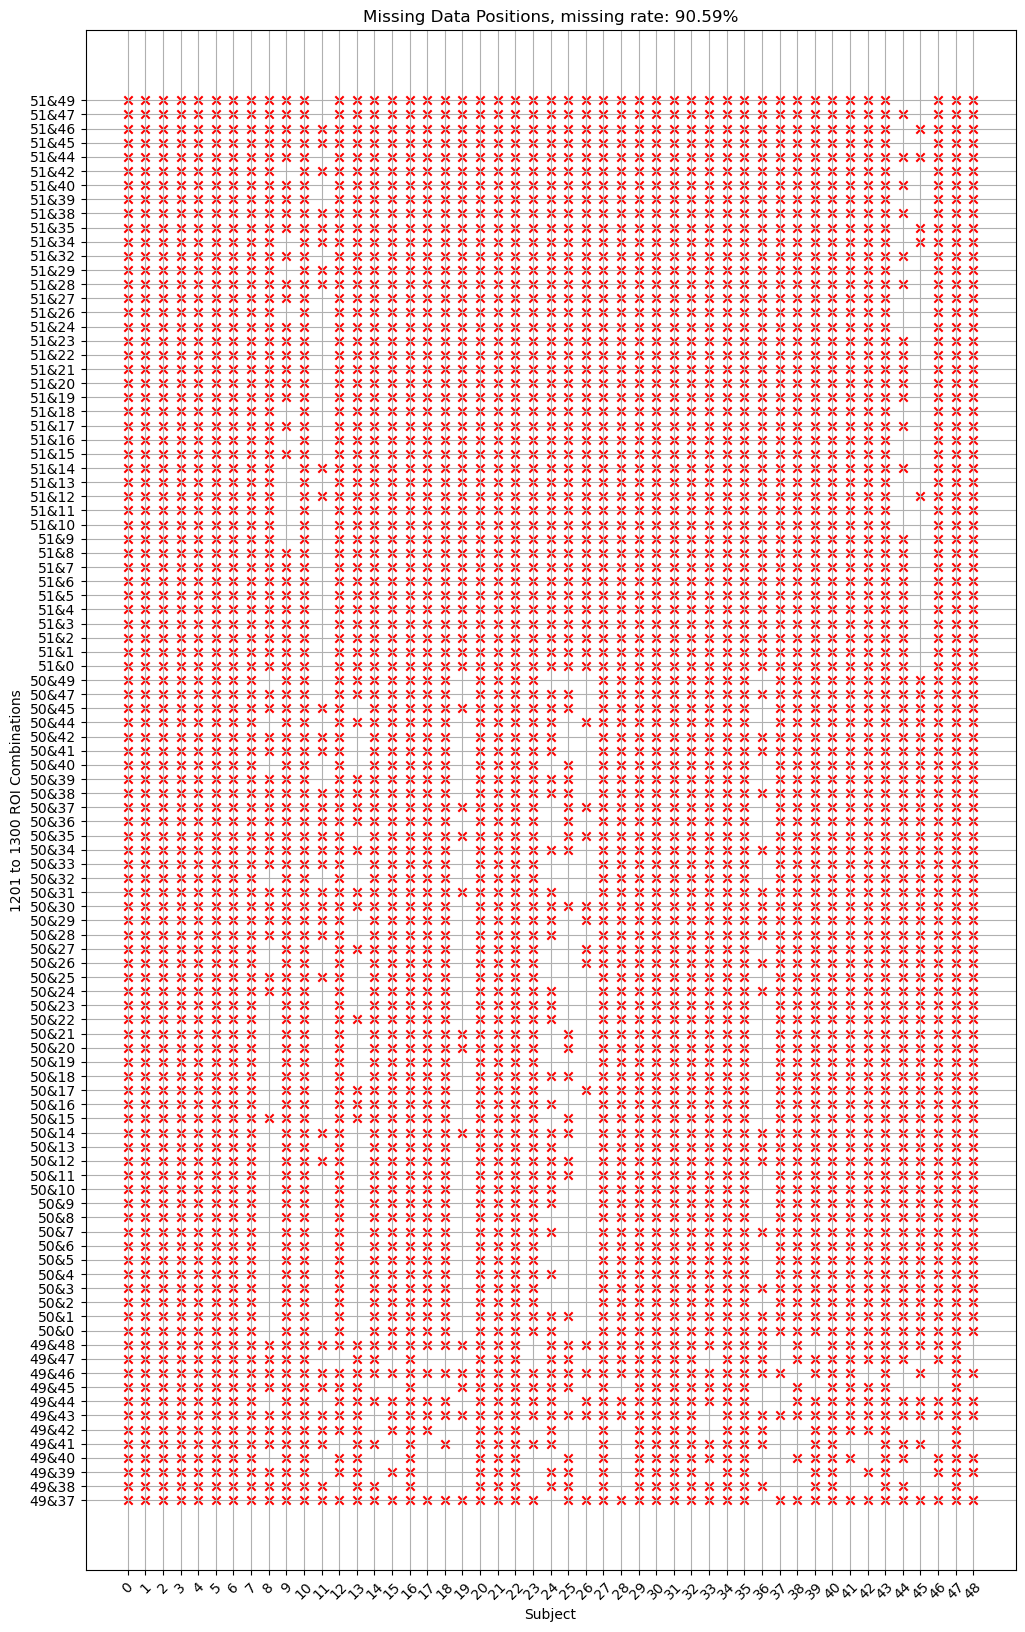

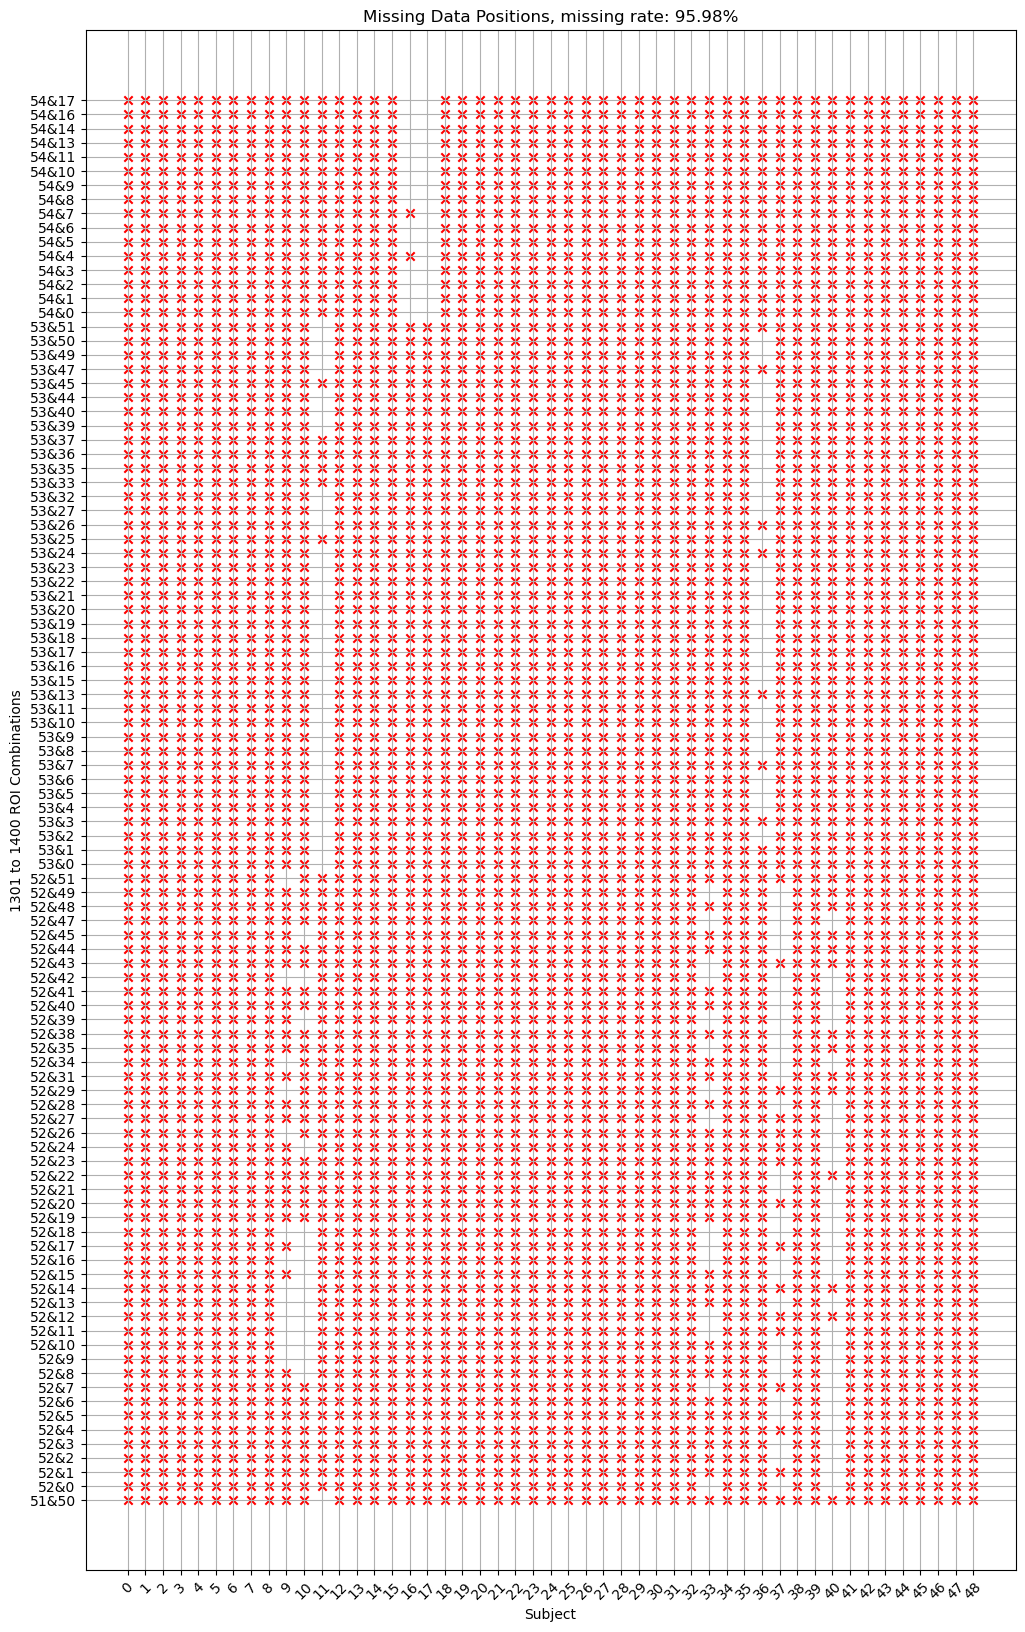

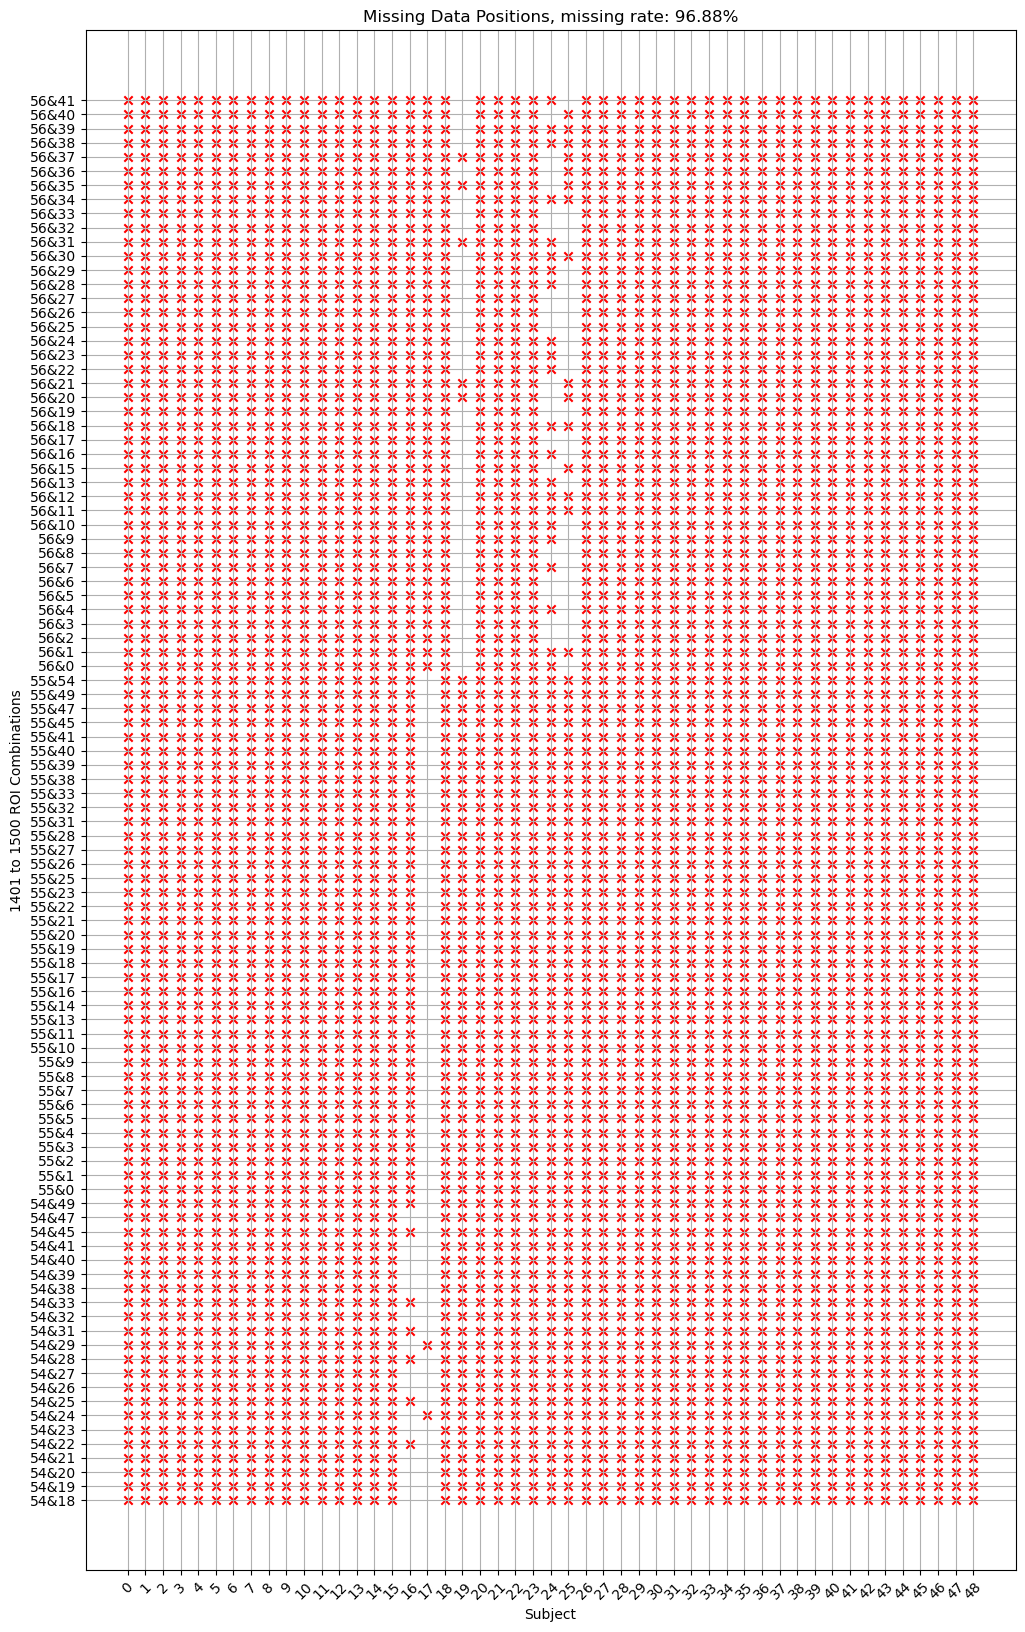

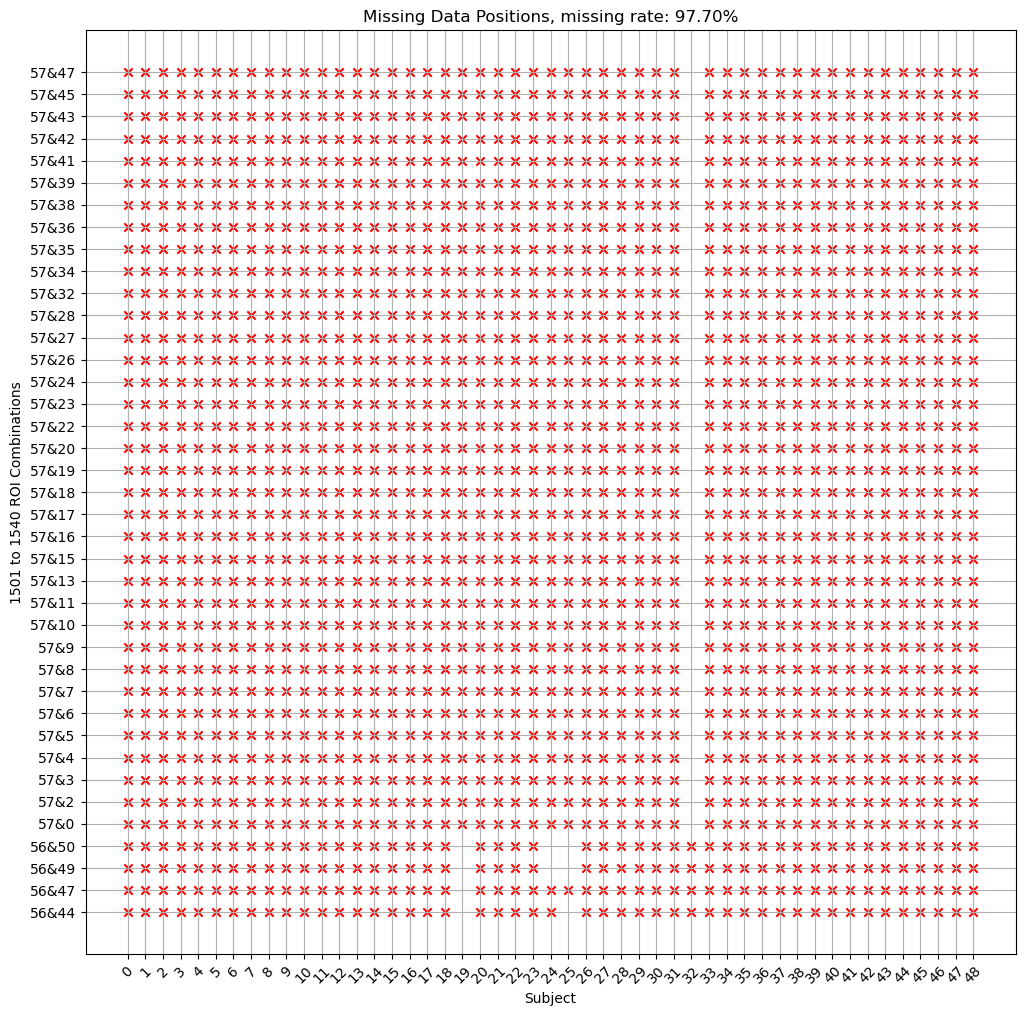

In [88]:
for m in range(1,16):
    missing_mask = np.isnan(X[(m-1)*100:m*100,:])
    missing_rate = np.sum(np.isnan(X[(m-1)*100:m*100,:]) == True) / (X[(m-1)*100:m*100,:].shape[0] * X[(m-1)*100:m*100,:].shape[1])
    x_coords, y_coords = np.where(missing_mask)
    plt.figure(figsize=(12, 20))
    plt.scatter(y_coords, x_coords, marker='x', color='red')
    plt.xlabel('Subject')
    plt.ylabel(f"{(m-1)*100 + 1} to {m*100} ROI Combinations")
    plt.title(f"Missing Data Positions, missing rate: {missing_rate*100:.2f}%")
    plt.xticks(np.arange(0,49), rotation=45)
    plt.yticks(range(100), col_name[(m-1)*100:m*100])
    plt.grid(True)
    plt.show()

missing_mask = np.isnan(X[1501:1541,:])
missing_rate = np.sum(np.isnan(X[1501:1541,:]) == True) / (X[1501:1541,:].shape[0] * X[1501:1541,:].shape[1])
x_coords, y_coords = np.where(missing_mask)
plt.figure(figsize=(12, 12))
plt.scatter(y_coords, x_coords, marker='x', color='red')
plt.xlabel('Subject')
plt.ylabel(f"1501 to 1540 ROI Combinations")
plt.title(f"Missing Data Positions, missing rate: {missing_rate*100:.2f}%")
plt.xticks(np.arange(0,49), rotation=45)
plt.yticks(range(39), col_name[1501:1541])
plt.grid(True)
plt.show()

In [36]:
# Synthetic data

# generate a regression dataset
X, y = make_regression(n_samples=50, n_features=1000, random_state=0)

# introduce missing values into the dataset
X_with_missing = X.copy()
missing_rate = 0.2  # set the rate of missing values
mask = np.random.choice([True, False], size=X.shape, p=[missing_rate, 1-missing_rate])
X_with_missing[mask] = np.nan
X_full = pd.DataFrame(X)

In [37]:
br_estimator = BayesianRidge()
N_SPLITS = 5

score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y, scoring="neg_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_with_missing, y, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
#     BayesianRidge(),
#     RandomForestRegressor(
#         # We tuned the hyperparameters of the RandomForestRegressor to get a good
#         # enough predictive performance for a restricted execution time.
#         n_estimators=4,
#         max_depth=10,
#         bootstrap=True,
#         max_samples=0.5,
#         n_jobs=2,
#         random_state=0,
#     ),
        Ridge(alpha=1e3),
    Lasso(alpha=1e3)
]
score_iterative_imputer = pd.DataFrame()
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-1, 1e-1)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=50, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_with_missing, y, scoring="neg_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)


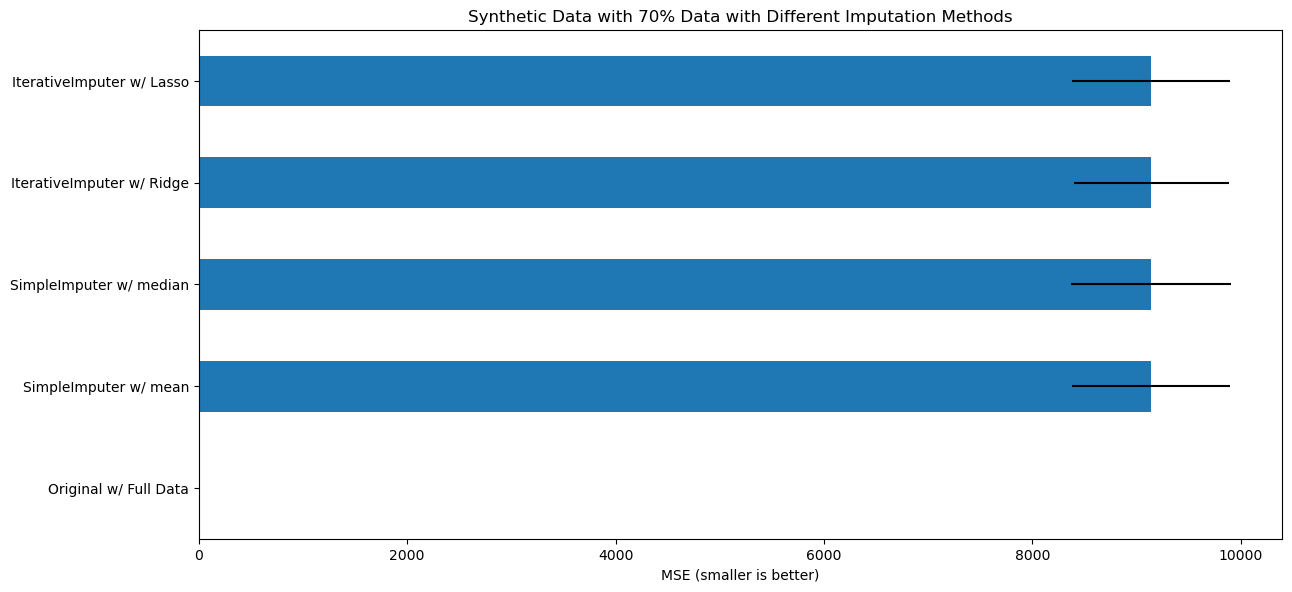

In [31]:
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Synthetic Data with 70% Data with Different Imputation Methods")
ax.set_xlabel("MSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

In [6]:
X_20_full, y_20 = make_regression(n_samples=50, n_features=800, random_state=42)

# introduce missing values into the dataset
X_20_with_missing = X_20_missing.copy()
missing_rate = 0.2  # set the rate of missing values
mask_20 = np.random.choice([True, False], size=X_20_with_missing.shape, p=[missing_rate, 1-missing_rate])
X_20_with_missing[mask] = np.nan
X_full_20 = pd.DataFrame(X_20_full)

NameError: name 'X_20_missing' is not defined